# 1. Imports

In [1]:
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis, skew, shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

warnings.filterwarnings('ignore')
random.seed(1032021)
np.random.seed(1032021)

# 2. Loading The Dataset

In [2]:
# the dataset
ds = pd.read_excel("data/07_14_22_data.xls",
                   sheet_name="All BC").T

# the wavenumber in cm-1
wavenumber = ds.iloc[0, 1:]
wavenumber.index = list(range(wavenumber.shape[0]))

ds = ds.iloc[1:, :]
ds = ds.drop(["LN Equinox", "Mystery"], axis=0)
ds = ds.reset_index(drop=True)

# the label of the sample
y = ds[0]

ds = ds.iloc[:, 1:]

# normalize the dataset
x = ds.copy()
x.columns = list(range(x.shape[1]))
x = scale(ds, axis=1)
x = pd.DataFrame(x)

# mean of the normalized absorbance
x_mean = x.mean()

# 3. Significant Peaks
## 3.1 Choosing The Peaks

In [3]:
# the peaks that we are looking up for the associated indexes
finding_peaks = [741, 775, 1375, 1454, 1596, 2850, 2920, 2950, 3044]

# list of indexes associates with the finding_peaks
peaks = []

# finding the indexes
for finding_idx in finding_peaks:
    finding_idx = x_mean[(wavenumber >= finding_idx - 0.5) & (wavenumber <= finding_idx + 0.5)].index[0]
    finding_idx = x_mean[(x_mean.index >= finding_idx - 10) & (x_mean.index <= finding_idx + 10)].idxmax()

    peaks.append(finding_idx)

# only keep the peaks
x_peaks = x.iloc[:, peaks]
wavenumber[peaks].values

array([745.3839, 776.2406, 1376.019, 1454.608, 1598.284, 2850.395,
       2919.822, 2944.894, 3046.142], dtype=object)

## 3.2 Visualizing The Peaks

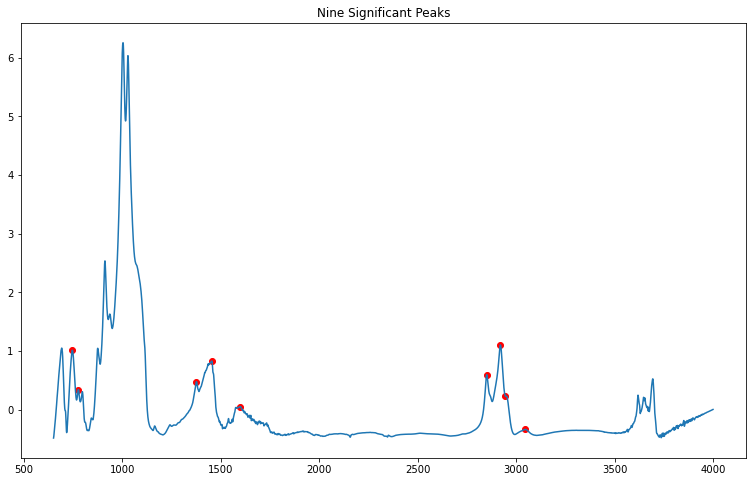

Num peaks:  9


In [4]:
fig = plt.figure(figsize=(13, 8))
plt.plot(wavenumber, x_mean)
plt.scatter(wavenumber[peaks], x_mean[peaks], c='red')
plt.title("Nine Significant Peaks")

plt.show()

print("Num peaks: ", len(peaks))

## 3.3 Skewness-Kurtosis Test For Nine Significant Peaks

In [5]:
# skewness test
skew(x_peaks).round(2)

array([0.09, 0.18, 1.27, 0.86, 0.77, 1.83, 1.67, 1.35, 0.81])

In [6]:
# kurtosis test
kurtosis(x_peaks, fisher=True).round(2)

array([-1.38, -0.56,  0.08, -0.61,  0.42,  4.4 ,  3.62,  2.32, -0.76])

## 3.4 Shapiro-Wilks Test For Nine Significant Peaks

In [7]:
# shapiro-wilks Test
for i in x_peaks.columns:
    print(shapiro(x.iloc[:, i]))

ShapiroResult(statistic=0.911432683467865, pvalue=0.01225939393043518)
ShapiroResult(statistic=0.9728774428367615, pvalue=0.5823143720626831)
ShapiroResult(statistic=0.7398757338523865, pvalue=3.636110477600596e-06)
ShapiroResult(statistic=0.8431714177131653, pvalue=0.0002961682912427932)
ShapiroResult(statistic=0.9263099431991577, pvalue=0.03094124048948288)
ShapiroResult(statistic=0.7758561372756958, pvalue=1.4800982171436772e-05)
ShapiroResult(statistic=0.7932258248329163, pvalue=3.0481029170914553e-05)
ShapiroResult(statistic=0.846514880657196, pvalue=0.0003490012895781547)
ShapiroResult(statistic=0.8597367405891418, pvalue=0.0006791875930503011)


## 3.5 Spearman Correlation Coefficients of The Nine Significant Peaks

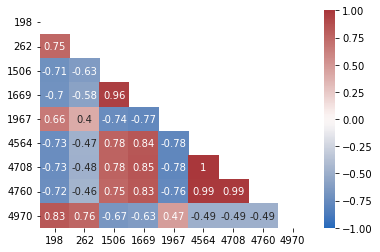

In [8]:
mask = np.triu(np.ones_like(x_peaks.corr(method='spearman'), dtype=bool))

sns.heatmap(x_peaks.corr(method='spearman').round(2),
            annot=True,
            vmax=1,
            vmin=-1,
            center=0,
            cmap='vlag',
            mask=mask)

plt.show()

# 4. PCA Visualization

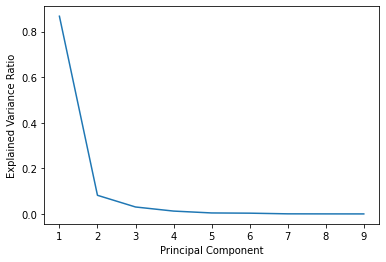

array([8.67297199e-01, 8.17087530e-02, 3.04366836e-02, 1.24718136e-02,
       4.25959950e-03, 3.28830246e-03, 3.77408193e-04, 1.38062227e-04,
       2.21788504e-05])

In [9]:
pca = PCA()
pca.fit(x_peaks)

# transform the x_peaks
reduction_peaks = pca.transform(x_peaks)

# plot the explained variance ratio
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.show()

pca.explained_variance_ratio_

## 4.1 2D Scatter Plot

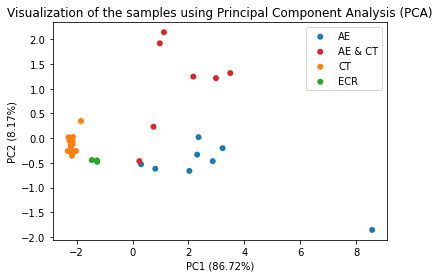

In [10]:
fig, ax = plt.subplots()
colors = ['tab:blue', 'tab:red', 'tab:orange', 'tab:green']

for idx in range(len(colors)):
    rows = [y == np.unique(y)[idx]]
    ax.scatter(reduction_peaks[:, 0][rows], reduction_peaks[:, 1][rows], c=colors[idx],
               label=np.unique(y)[idx], edgecolors='none')

ax.set_xlabel("PC1 (86.72%)")
ax.set_ylabel("PC2 (8.17%)")
ax.set_title("Visualization of the samples using Principal Component Analysis (PCA)")
ax.legend()

extent = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('test5.png', bbox_inches=extent.expanded(1, 1))

ax.legend()
plt.show()

## 4.2 3D Scatter Plot

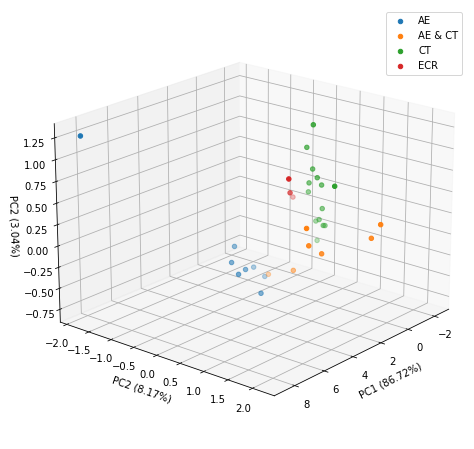

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for i in y.unique():
    idx = y == i

    a = reduction_peaks[:, 0][idx]
    b = reduction_peaks[:, 1][idx]
    c = reduction_peaks[:, 2][idx]
    ax.scatter(a, b, c, label=f'{i}')

    ax.set_xlabel("PC1 (86.72%)")
    ax.set_ylabel("PC2 (8.17%)")
    ax.set_zlabel("PC2 (3.04%)")

ax.view_init(20, 40)
plt.legend()
plt.show()